In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import h5py
from IPython.display import display
import numpy as np
from os.path import join as pj
import pandas as pd
import random
import sys
import torch
from tqdm import tqdm
import visdom

# Logger
from IO.logger import Logger
# Data Augument
from dataset.classification.loader import create_validation_split, load_validation_data, create_train_data
# Model
from model.resnet.utils import define_weight
from model.resnet.predict import test_classification
# Evaluation
from evaluation.classification.evaluate import accuracy, confusion_matrix
# Statistics
from evaluation.classification.statistics import compute_each_size_df, compute_all_size_df
# Visualize
from evaluation.classification.visualize import create_confusion_matrix, plot_df_distrib_size

# Train Config

In [3]:
class args:
    # experiment_name
    experiment_name = "resnet50_b20_r45_lr1e-5_crossvalid_resize_other"
    # data split
    train_ratio = 0.8 # unused parameters
    test_ratio = 0.2
    # paths
    all_data_path = "/home/tanida/workspace/Insect_Phenology_Detector/data/all_classification_data/classify_insect_std_resize_aquatic_other"
    model_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/classification/ResNet101", experiment_name)
    figure_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/figure/classification/ResNet101", experiment_name)
    # class names to visualize
    #labels =  ['Aquatic_insects', 'Other_insects']
    labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
               'Lepidoptera', 'Plecoptera', 'Trichoptera', 'Other_insects']
    # train config
    model_name = "ResNet50" # choice ["ResNet18", "ResNet34", "ResNet50", "ResNet101"]
    bs = 20
    lr = 1e-5
    nepoch = 40
    rotate = 45
    pretrain = True
    # test config
    save_fig = True
    save_df = True
    # visdom
    visdom = True
    port = 8097

# Load Model

In [4]:
# Model
if args.model_name=="ResNet18":
    from model.resnet.resnet18 import ResNet18
elif args.model_name=="ResNet34":
    from model.resnet.resnet34 import ResNet34
elif args.model_name=="ResNet50":
    from model.resnet.resnet50 import ResNet50
elif args.model_name=="ResNet101":
    from model.resnet.resnet101 import ResNet101
else:
    print("error! write correct model name!")

# Train

In [5]:
def train(model, xtr, ytr, bs=10, lr=1e-4, nepoch=200, visdom=False):
    # calculate counts and count_sum
    _, counts = np.unique(ytr, return_counts=True)
    counts_sum = counts.sum()
    
    # define weight and create loss function
    ce = torch.nn.CrossEntropyLoss(define_weight(counts))
    
    # define optimizer
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    # set model train mode
    model.train()
    
    t = tqdm(range(nepoch),leave=False)
    # training
    for epoch in t:
        total_loss = 0
        index = random.sample(range(counts_sum),counts_sum)
        t.set_description("epoch=%s" % (epoch))
        for idx in range(0,counts_sum-bs,bs):
            idx = index[idx:idx+bs]
            x = xtr[idx].cuda()
            y = ytr[idx].cuda()
            opt.zero_grad()
            out = model(x)
            loss = ce(out, y)
            total_loss += loss
            loss.backward()
            opt.step()
        
        te_acc = accuracy(model, xte, yte, bs)
        total_loss = total_loss.item()
        if visdom:
            visualize(vis, epoch, total_loss, win_train_loss)
            visualize(vis, epoch, te_acc, win_test_acc)
        sys.stdout.write("\rtotal_loss=%f, te_acc=%f" % (total_loss,te_acc))
        sys.stdout.flush()

# Set Visdom

In [6]:
if args.visdom:
    # Create visdom
    vis = visdom.Visdom(port=args.port)
    
    """train_lossl"""
    win_train_loss = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='train_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    """test_accuracy"""
    win_test_acc = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='test_accuracy',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )

Setting up a new session...


In [7]:
def visualize(vis, phase, visualized_data, window):
    vis.line(
        X=np.array([phase]),
        Y=np.array([visualized_data]),
        update='append',
        win=window
    )

### Save args

In [8]:
args_logger = Logger(args)
args_logger.save()

# Cross Validation

In [9]:
model_save_path = pj(args.model_root, "final.pth")
if os.path.exists(args.model_root) is False:
    os.makedirs(args.model_root)
if os.path.exists(args.figure_root) is False:
    os.makedirs(args.figure_root)

In [10]:
valid_num = int(1.0/args.test_ratio)
with h5py.File(args.all_data_path) as f:
    X = f["X"][:]
    Y = f["Y"][:]
_, ntests = np.unique(Y, return_counts=True)
train_idxs, test_idxs = create_validation_split(Y, args.test_ratio)
result = []
for valid_count in range(valid_num):
    xtr, ytr, xte, yte = load_validation_data(X, Y, train_idxs[valid_count], test_idxs[valid_count])
    
    xtr, ytr = create_train_data(xtr, ytr, args.rotate)
    
    if args.model_name=="ResNet18":
        model = ResNet18(len(args.labels), pretrain=args.pretrain).cuda()
    elif args.model_name=="ResNet34":
        model = ResNet34(len(args.labels), pretrain=args.pretrain).cuda()
    elif args.model_name=="ResNet50":
        model = ResNet50(len(args.labels), pretrain=args.pretrain).cuda()
    elif args.model_name=="ResNet101":
        model = ResNet101(len(args.labels), pretrain=args.pretrain).cuda()
    else:
        print("error! write correct model name!")
    train(model, xtr, ytr, bs=args.bs, lr=args.lr, nepoch=args.nepoch, visdom=args.visdom)
    torch.save(model.state_dict(), model_save_path)
    
    matrix = confusion_matrix(model, xte, yte, args.labels, bs=args.bs)
    df = pd.DataFrame(matrix)
    display(df)
    if valid_count == 0:
        validation_matrix = matrix
        x_all = xte.cpu().numpy()
        y_all = yte.cpu().numpy()
    else:
        validation_matrix += matrix
        x_all = np.concatenate([x_all, xte.cpu().numpy()])
        y_all = np.concatenate([y_all, yte.cpu().numpy()])
    
    result.extend(test_classification(model, xte))

  0%|          | 2/2865 [00:00<04:26, 10.74it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

total_loss=912.401001, te_acc=0.853556

epoch=1:   2%|▎         | 1/40 [01:58<1:16:47, 118.15s/it]

total_loss=375.607513, te_acc=0.834031

epoch=2:   5%|▌         | 2/40 [04:00<1:15:42, 119.55s/it]

total_loss=219.651169, te_acc=0.807531

epoch=3:   8%|▊         | 3/40 [06:04<1:14:32, 120.88s/it]

total_loss=137.108429, te_acc=0.822873

epoch=4:  10%|█         | 4/40 [08:08<1:12:57, 121.60s/it]

total_loss=103.407875, te_acc=0.842399

epoch=5:  12%|█▎        | 5/40 [10:11<1:11:14, 122.14s/it]

total_loss=76.261116, te_acc=0.873082

epoch=6:  15%|█▌        | 6/40 [12:14<1:09:21, 122.40s/it]

total_loss=53.182178, te_acc=0.852162

epoch=7:  18%|█▊        | 7/40 [14:17<1:07:27, 122.67s/it]

total_loss=46.839977, te_acc=0.868898

epoch=8:  20%|██        | 8/40 [16:20<1:05:25, 122.67s/it]

total_loss=34.477459, te_acc=0.863319

epoch=9:  22%|██▎       | 9/40 [18:23<1:03:27, 122.82s/it]

total_loss=33.548180, te_acc=0.825662

epoch=10:  25%|██▌       | 10/40 [20:27<1:01:29, 122.98s/it]

total_loss=27.937386, te_acc=0.866109

epoch=11:  28%|██▊       | 11/40 [22:30<59:30, 123.12s/it]  

total_loss=27.703711, te_acc=0.847978

epoch=12:  30%|███       | 12/40 [24:33<57:28, 123.15s/it]

total_loss=20.723694, te_acc=0.880056

epoch=13:  32%|███▎      | 13/40 [26:37<55:27, 123.24s/it]

total_loss=21.641527, te_acc=0.881450

epoch=14:  35%|███▌      | 14/40 [28:40<53:26, 123.32s/it]

total_loss=15.431460, te_acc=0.863319

epoch=15:  38%|███▊      | 15/40 [30:44<51:27, 123.49s/it]

total_loss=27.707125, te_acc=0.882845

epoch=16:  40%|████      | 16/40 [32:48<49:25, 123.56s/it]

total_loss=15.372052, te_acc=0.866109

epoch=17:  42%|████▎     | 17/40 [34:52<47:22, 123.59s/it]

total_loss=17.530293, te_acc=0.874477

epoch=18:  45%|████▌     | 18/40 [36:55<45:19, 123.60s/it]

total_loss=10.383169, te_acc=0.866109

epoch=19:  48%|████▊     | 19/40 [38:58<43:12, 123.47s/it]

total_loss=12.817930, te_acc=0.857741

epoch=20:  50%|█████     | 20/40 [41:02<41:10, 123.51s/it]

total_loss=26.117855, te_acc=0.874477

epoch=21:  52%|█████▎    | 21/40 [43:05<39:06, 123.51s/it]

total_loss=16.817188, te_acc=0.868898

epoch=22:  55%|█████▌    | 22/40 [45:09<37:02, 123.46s/it]

total_loss=12.610911, te_acc=0.874477

epoch=23:  57%|█████▊    | 23/40 [47:12<34:56, 123.34s/it]

total_loss=7.309103, te_acc=0.867503

epoch=24:  60%|██████    | 24/40 [49:15<32:52, 123.29s/it]

total_loss=13.328890, te_acc=0.880056

epoch=25:  62%|██████▎   | 25/40 [51:19<30:51, 123.43s/it]

total_loss=10.112090, te_acc=0.873082

epoch=26:  65%|██████▌   | 26/40 [53:22<28:47, 123.41s/it]

total_loss=7.655054, te_acc=0.866109

epoch=27:  68%|██████▊   | 27/40 [55:26<26:44, 123.45s/it]

total_loss=14.067520, te_acc=0.887029

epoch=28:  70%|███████   | 28/40 [57:29<24:40, 123.36s/it]

total_loss=9.067062, te_acc=0.889819

epoch=29:  72%|███████▎  | 29/40 [59:32<22:37, 123.41s/it]

total_loss=5.833310, te_acc=0.887029

epoch=30:  75%|███████▌  | 30/40 [1:01:36<20:34, 123.42s/it]

total_loss=6.147094, te_acc=0.853556

epoch=31:  78%|███████▊  | 31/40 [1:03:39<18:30, 123.39s/it]

total_loss=17.127998, te_acc=0.860530

epoch=32:  80%|████████  | 32/40 [1:05:42<16:26, 123.36s/it]

total_loss=8.129306, te_acc=0.864714

epoch=33:  82%|████████▎ | 33/40 [1:07:46<14:23, 123.37s/it]

total_loss=5.170725, te_acc=0.875872

epoch=34:  85%|████████▌ | 34/40 [1:09:49<12:20, 123.43s/it]

total_loss=7.426623, te_acc=0.868898

epoch=35:  88%|████████▊ | 35/40 [1:11:53<10:17, 123.44s/it]

total_loss=13.490049, te_acc=0.856346

epoch=36:  90%|█████████ | 36/40 [1:13:56<08:13, 123.48s/it]

total_loss=8.528229, te_acc=0.875872

epoch=37:  92%|█████████▎| 37/40 [1:16:00<06:10, 123.45s/it]

total_loss=7.250367, te_acc=0.875872

epoch=38:  95%|█████████▌| 38/40 [1:18:03<04:07, 123.52s/it]

total_loss=8.526185, te_acc=0.873082

epoch=39:  98%|█████████▊| 39/40 [1:20:07<02:03, 123.45s/it]

total_loss=11.786250, te_acc=0.870293

,0,1,2,3,4,5,6
0,56.0,0.0,1.0,1.0,0.0,1.0,25.0
1,0.0,8.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,26.0,0.0,3.0,2.0,9.0
3,0.0,0.0,1.0,48.0,0.0,2.0,3.0
4,0.0,0.0,0.0,0.0,20.0,3.0,4.0
5,0.0,0.0,0.0,1.0,1.0,47.0,1.0
6,17.0,0.0,7.0,1.0,4.0,4.0,419.0


  0%|          | 2/2865 [00:00<04:36, 10.34it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

total_loss=928.396118, te_acc=0.793584

epoch=1:   2%|▎         | 1/40 [01:59<1:17:45, 119.63s/it]

total_loss=366.161224, te_acc=0.814505

epoch=2:   5%|▌         | 2/40 [04:03<1:16:35, 120.94s/it]

total_loss=217.181305, te_acc=0.800558

epoch=3:   8%|▊         | 3/40 [06:07<1:15:11, 121.92s/it]

total_loss=138.411636, te_acc=0.821478

epoch=4:  10%|█         | 4/40 [08:12<1:13:33, 122.59s/it]

total_loss=96.889732, te_acc=0.828452

epoch=5:  12%|█▎        | 5/40 [10:15<1:11:42, 122.92s/it]

total_loss=70.386993, te_acc=0.831241

epoch=6:  15%|█▌        | 6/40 [12:19<1:09:46, 123.12s/it]

total_loss=69.204308, te_acc=0.815900

epoch=7:  18%|█▊        | 7/40 [14:22<1:07:48, 123.30s/it]

total_loss=41.845383, te_acc=0.807531

epoch=8:  20%|██        | 8/40 [16:26<1:05:50, 123.46s/it]

total_loss=48.859970, te_acc=0.861925

epoch=9:  22%|██▎       | 9/40 [18:30<1:03:49, 123.54s/it]

total_loss=28.008032, te_acc=0.854951

epoch=10:  25%|██▌       | 10/40 [20:34<1:01:48, 123.62s/it]

total_loss=23.955572, te_acc=0.866109

epoch=11:  28%|██▊       | 11/40 [22:38<59:46, 123.66s/it]  

total_loss=34.831928, te_acc=0.861925

epoch=12:  30%|███       | 12/40 [24:41<57:42, 123.67s/it]

total_loss=30.787888, te_acc=0.857741

epoch=13:  32%|███▎      | 13/40 [26:45<55:39, 123.67s/it]

total_loss=18.128763, te_acc=0.846583

epoch=14:  35%|███▌      | 14/40 [28:48<53:33, 123.59s/it]

total_loss=17.224331, te_acc=0.845188

epoch=15:  38%|███▊      | 15/40 [30:51<51:26, 123.45s/it]

total_loss=12.853494, te_acc=0.856346

epoch=16:  40%|████      | 16/40 [32:54<49:17, 123.24s/it]

total_loss=20.823812, te_acc=0.838215

epoch=17:  42%|████▎     | 17/40 [34:57<47:12, 123.17s/it]

total_loss=22.545597, te_acc=0.845188

epoch=18:  45%|████▌     | 18/40 [37:01<45:11, 123.25s/it]

total_loss=14.697227, te_acc=0.845188

epoch=19:  48%|████▊     | 19/40 [39:04<43:08, 123.26s/it]

total_loss=11.114255, te_acc=0.866109

epoch=20:  50%|█████     | 20/40 [41:07<41:05, 123.30s/it]

total_loss=25.384808, te_acc=0.845188

epoch=21:  52%|█████▎    | 21/40 [43:11<39:04, 123.42s/it]

total_loss=21.878571, te_acc=0.856346

epoch=22:  55%|█████▌    | 22/40 [45:14<37:01, 123.42s/it]

total_loss=5.742313, te_acc=0.863319

epoch=23:  57%|█████▊    | 23/40 [47:18<34:57, 123.41s/it]

total_loss=6.981794, te_acc=0.859135

epoch=24:  60%|██████    | 24/40 [49:21<32:54, 123.42s/it]

total_loss=13.416271, te_acc=0.852162

epoch=25:  62%|██████▎   | 25/40 [51:25<30:51, 123.43s/it]

total_loss=22.542336, te_acc=0.852162

epoch=26:  65%|██████▌   | 26/40 [53:28<28:48, 123.48s/it]

total_loss=11.609754, te_acc=0.861925

epoch=27:  68%|██████▊   | 27/40 [55:32<26:46, 123.55s/it]

total_loss=10.663484, te_acc=0.866109

epoch=28:  70%|███████   | 28/40 [57:35<24:42, 123.51s/it]

total_loss=4.476110, te_acc=0.864714

epoch=29:  72%|███████▎  | 29/40 [59:39<22:38, 123.48s/it]

total_loss=6.694080, te_acc=0.860530

epoch=30:  75%|███████▌  | 30/40 [1:01:42<20:34, 123.42s/it]

total_loss=7.697921, te_acc=0.863319

epoch=31:  78%|███████▊  | 31/40 [1:03:45<18:30, 123.37s/it]

total_loss=11.766224, te_acc=0.859135

epoch=32:  80%|████████  | 32/40 [1:05:49<16:26, 123.36s/it]

total_loss=18.524990, te_acc=0.854951

epoch=33:  82%|████████▎ | 33/40 [1:07:52<14:23, 123.39s/it]

total_loss=6.417265, te_acc=0.852162

epoch=34:  85%|████████▌ | 34/40 [1:09:56<12:21, 123.53s/it]

total_loss=6.296985, te_acc=0.854951

epoch=35:  88%|████████▊ | 35/40 [1:12:00<10:17, 123.60s/it]

total_loss=8.094297, te_acc=0.859135

epoch=36:  90%|█████████ | 36/40 [1:14:03<08:13, 123.48s/it]

total_loss=12.407379, te_acc=0.860530

epoch=37:  92%|█████████▎| 37/40 [1:16:07<06:10, 123.47s/it]

total_loss=12.776111, te_acc=0.853556

epoch=38:  95%|█████████▌| 38/40 [1:18:10<04:06, 123.38s/it]

total_loss=4.232078, te_acc=0.860530

epoch=39:  98%|█████████▊| 39/40 [1:20:13<02:03, 123.36s/it]

total_loss=7.340673, te_acc=0.839609

,0,1,2,3,4,5,6
0,55.0,0.0,2.0,2.0,0.0,0.0,25.0
1,0.0,8.0,2.0,0.0,0.0,0.0,0.0
2,3.0,1.0,21.0,2.0,0.0,0.0,13.0
3,0.0,0.0,0.0,51.0,0.0,1.0,2.0
4,0.0,0.0,1.0,0.0,21.0,0.0,5.0
5,0.0,1.0,0.0,1.0,0.0,44.0,4.0
6,20.0,0.0,12.0,8.0,5.0,5.0,402.0


  0%|          | 2/2865 [00:00<04:37, 10.33it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

total_loss=971.501404, te_acc=0.847978

epoch=1:   2%|▎         | 1/40 [01:59<1:17:48, 119.70s/it]

total_loss=386.889801, te_acc=0.873082

epoch=2:   5%|▌         | 2/40 [04:04<1:16:41, 121.08s/it]

total_loss=239.787491, te_acc=0.863319

epoch=3:   8%|▊         | 3/40 [06:07<1:15:01, 121.68s/it]

total_loss=162.086288, te_acc=0.857741

epoch=4:  10%|█         | 4/40 [08:09<1:13:13, 122.03s/it]

total_loss=114.767525, te_acc=0.868898

epoch=5:  12%|█▎        | 5/40 [10:12<1:11:21, 122.32s/it]

total_loss=90.031700, te_acc=0.892608

epoch=6:  15%|█▌        | 6/40 [12:15<1:09:25, 122.50s/it]

total_loss=55.113708, te_acc=0.888424

epoch=7:  18%|█▊        | 7/40 [14:18<1:07:27, 122.64s/it]

total_loss=51.887234, te_acc=0.881450

epoch=8:  20%|██        | 8/40 [16:21<1:05:27, 122.74s/it]

total_loss=42.006657, te_acc=0.881450

epoch=9:  22%|██▎       | 9/40 [18:25<1:03:29, 122.89s/it]

total_loss=33.026909, te_acc=0.882845

epoch=10:  25%|██▌       | 10/40 [20:28<1:01:30, 123.03s/it]

total_loss=31.057056, te_acc=0.899582

epoch=11:  28%|██▊       | 11/40 [22:31<59:32, 123.18s/it]  

total_loss=27.250879, te_acc=0.873082

epoch=12:  30%|███       | 12/40 [24:34<57:26, 123.11s/it]

total_loss=32.404705, te_acc=0.874477

epoch=13:  32%|███▎      | 13/40 [26:38<55:26, 123.20s/it]

total_loss=19.481123, te_acc=0.892608

epoch=14:  35%|███▌      | 14/40 [28:41<53:21, 123.13s/it]

total_loss=21.285168, te_acc=0.868898

epoch=15:  38%|███▊      | 15/40 [30:44<51:17, 123.09s/it]

total_loss=16.524414, te_acc=0.870293

epoch=16:  40%|████      | 16/40 [32:46<49:11, 122.97s/it]

total_loss=26.311874, te_acc=0.891213

epoch=17:  42%|████▎     | 17/40 [34:50<47:09, 123.01s/it]

total_loss=17.066631, te_acc=0.884240

epoch=18:  45%|████▌     | 18/40 [36:52<45:04, 122.91s/it]

total_loss=12.531299, te_acc=0.874477

epoch=19:  48%|████▊     | 19/40 [38:55<42:59, 122.81s/it]

total_loss=13.130867, te_acc=0.891213

epoch=20:  50%|█████     | 20/40 [40:58<40:56, 122.82s/it]

total_loss=14.887674, te_acc=0.887029

epoch=21:  52%|█████▎    | 21/40 [43:01<38:55, 122.89s/it]

total_loss=21.305439, te_acc=0.899582

epoch=22:  55%|█████▌    | 22/40 [45:04<36:52, 122.94s/it]

total_loss=17.000704, te_acc=0.888424

epoch=23:  57%|█████▊    | 23/40 [47:07<34:51, 123.00s/it]

total_loss=19.003805, te_acc=0.902371

epoch=24:  60%|██████    | 24/40 [49:10<32:49, 123.09s/it]

total_loss=14.060694, te_acc=0.898187

epoch=25:  62%|██████▎   | 25/40 [51:13<30:45, 123.04s/it]

total_loss=13.039371, te_acc=0.873082

epoch=26:  65%|██████▌   | 26/40 [53:16<28:42, 123.02s/it]

total_loss=6.933471, te_acc=0.900976

epoch=27:  68%|██████▊   | 27/40 [55:19<26:38, 122.98s/it]

total_loss=14.848242, te_acc=0.875872

epoch=28:  70%|███████   | 28/40 [57:22<24:37, 123.09s/it]

total_loss=15.092547, te_acc=0.898187

epoch=29:  72%|███████▎  | 29/40 [59:26<22:34, 123.17s/it]

total_loss=8.108474, te_acc=0.888424

epoch=30:  75%|███████▌  | 30/40 [1:01:29<20:30, 123.08s/it]

total_loss=9.780512, te_acc=0.889819

epoch=31:  78%|███████▊  | 31/40 [1:03:32<18:28, 123.17s/it]

total_loss=7.955916, te_acc=0.884240

epoch=32:  80%|████████  | 32/40 [1:05:35<16:25, 123.20s/it]

total_loss=6.119607, te_acc=0.898187

epoch=33:  82%|████████▎ | 33/40 [1:07:39<14:23, 123.30s/it]

total_loss=16.961832, te_acc=0.887029

epoch=34:  85%|████████▌ | 34/40 [1:09:42<12:20, 123.35s/it]

total_loss=8.176015, te_acc=0.895397

epoch=35:  88%|████████▊ | 35/40 [1:11:45<10:16, 123.27s/it]

total_loss=9.332611, te_acc=0.902371

epoch=36:  90%|█████████ | 36/40 [1:13:49<08:13, 123.28s/it]

total_loss=3.382432, te_acc=0.892608

epoch=37:  92%|█████████▎| 37/40 [1:15:52<06:09, 123.30s/it]

total_loss=9.339392, te_acc=0.900976

epoch=38:  95%|█████████▌| 38/40 [1:17:55<04:06, 123.23s/it]

total_loss=16.309444, te_acc=0.891213

epoch=39:  98%|█████████▊| 39/40 [1:19:58<02:03, 123.24s/it]

total_loss=4.476176, te_acc=0.905160

,0,1,2,3,4,5,6
0,65.0,0.0,3.0,2.0,1.0,0.0,13.0
1,0.0,9.0,1.0,0.0,0.0,0.0,0.0
2,0.0,3.0,31.0,0.0,0.0,0.0,6.0
3,0.0,0.0,1.0,49.0,0.0,3.0,1.0
4,0.0,0.0,1.0,0.0,23.0,0.0,3.0
5,0.0,0.0,0.0,3.0,0.0,45.0,2.0
6,10.0,0.0,3.0,1.0,9.0,2.0,427.0


  0%|          | 2/2865 [00:00<04:23, 10.85it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

total_loss=946.658447, te_acc=0.799163

epoch=1:   2%|▎         | 1/40 [01:59<1:17:51, 119.78s/it]

total_loss=393.737518, te_acc=0.854951

epoch=2:   5%|▌         | 2/40 [04:03<1:16:39, 121.05s/it]

total_loss=231.046661, te_acc=0.838215

epoch=3:   8%|▊         | 3/40 [06:07<1:15:09, 121.88s/it]

total_loss=153.941193, te_acc=0.847978

epoch=4:  10%|█         | 4/40 [08:11<1:13:27, 122.42s/it]

total_loss=111.994629, te_acc=0.863319

epoch=5:  12%|█▎        | 5/40 [10:14<1:11:37, 122.78s/it]

total_loss=61.126995, te_acc=0.845188

epoch=6:  15%|█▌        | 6/40 [12:18<1:09:45, 123.11s/it]

total_loss=68.371788, te_acc=0.871688

epoch=7:  18%|█▊        | 7/40 [14:22<1:07:46, 123.23s/it]

total_loss=48.733707, te_acc=0.868898

epoch=8:  20%|██        | 8/40 [16:25<1:05:44, 123.26s/it]

total_loss=46.081352, te_acc=0.884240

epoch=9:  22%|██▎       | 9/40 [18:28<1:03:41, 123.27s/it]

total_loss=25.566624, te_acc=0.860530

epoch=10:  25%|██▌       | 10/40 [20:32<1:01:40, 123.34s/it]

total_loss=34.715313, te_acc=0.857741

epoch=11:  28%|██▊       | 11/40 [22:35<59:38, 123.40s/it]  

total_loss=19.042179, te_acc=0.860530

epoch=12:  30%|███       | 12/40 [24:39<57:36, 123.46s/it]

total_loss=26.003326, te_acc=0.874477

epoch=13:  32%|███▎      | 13/40 [26:43<55:34, 123.51s/it]

total_loss=29.496986, te_acc=0.864714

epoch=14:  35%|███▌      | 14/40 [28:46<53:30, 123.47s/it]

total_loss=16.013111, te_acc=0.846583

epoch=15:  38%|███▊      | 15/40 [30:50<51:26, 123.47s/it]

total_loss=19.183655, te_acc=0.868898

epoch=16:  40%|████      | 16/40 [32:53<49:24, 123.54s/it]

total_loss=23.430033, te_acc=0.846583

epoch=17:  42%|████▎     | 17/40 [34:57<47:21, 123.54s/it]

total_loss=14.035279, te_acc=0.889819

epoch=18:  45%|████▌     | 18/40 [37:00<45:18, 123.58s/it]

total_loss=21.817291, te_acc=0.845188

epoch=19:  48%|████▊     | 19/40 [39:04<43:14, 123.54s/it]

total_loss=12.555777, te_acc=0.888424

epoch=20:  50%|█████     | 20/40 [41:08<41:12, 123.61s/it]

total_loss=4.881222, te_acc=0.875872

epoch=21:  52%|█████▎    | 21/40 [43:11<39:08, 123.59s/it]

total_loss=20.846542, te_acc=0.852162

epoch=22:  55%|█████▌    | 22/40 [45:15<37:04, 123.58s/it]

total_loss=20.688349, te_acc=0.860530

epoch=23:  57%|█████▊    | 23/40 [47:18<35:01, 123.61s/it]

total_loss=12.026190, te_acc=0.880056

epoch=24:  60%|██████    | 24/40 [49:22<32:58, 123.66s/it]

total_loss=8.133899, te_acc=0.882845

epoch=25:  62%|██████▎   | 25/40 [51:26<30:54, 123.66s/it]

total_loss=15.124434, te_acc=0.880056

epoch=26:  65%|██████▌   | 26/40 [53:30<28:51, 123.65s/it]

total_loss=6.339988, te_acc=0.871688

epoch=27:  68%|██████▊   | 27/40 [55:33<26:47, 123.64s/it]

total_loss=27.070702, te_acc=0.864714

epoch=28:  70%|███████   | 28/40 [57:37<24:43, 123.61s/it]

total_loss=6.991142, te_acc=0.878661

epoch=29:  72%|███████▎  | 29/40 [59:40<22:37, 123.43s/it]

total_loss=13.169321, te_acc=0.880056

epoch=30:  75%|███████▌  | 30/40 [1:01:43<20:34, 123.42s/it]

total_loss=13.094156, te_acc=0.888424

epoch=31:  78%|███████▊  | 31/40 [1:03:47<18:31, 123.46s/it]

total_loss=7.349454, te_acc=0.884240

epoch=32:  80%|████████  | 32/40 [1:05:50<16:28, 123.56s/it]

total_loss=16.361830, te_acc=0.857741

epoch=33:  82%|████████▎ | 33/40 [1:07:54<14:24, 123.57s/it]

total_loss=6.258637, te_acc=0.888424

epoch=34:  85%|████████▌ | 34/40 [1:09:58<12:21, 123.60s/it]

total_loss=3.881457, te_acc=0.873082

epoch=35:  88%|████████▊ | 35/40 [1:12:01<10:17, 123.54s/it]

total_loss=17.103752, te_acc=0.891213

epoch=36:  90%|█████████ | 36/40 [1:14:05<08:14, 123.52s/it]

total_loss=7.748833, te_acc=0.868898

epoch=37:  92%|█████████▎| 37/40 [1:16:08<06:10, 123.37s/it]

total_loss=7.664176, te_acc=0.884240

epoch=38:  95%|█████████▌| 38/40 [1:18:11<04:06, 123.32s/it]

total_loss=5.672187, te_acc=0.894003

epoch=39:  98%|█████████▊| 39/40 [1:20:14<02:03, 123.27s/it]

total_loss=9.857103, te_acc=0.885635

,0,1,2,3,4,5,6
0,61.0,0.0,1.0,0.0,0.0,0.0,22.0
1,0.0,9.0,1.0,0.0,0.0,0.0,0.0
2,1.0,2.0,24.0,1.0,0.0,3.0,9.0
3,0.0,0.0,0.0,48.0,0.0,2.0,4.0
4,0.0,0.0,0.0,0.0,23.0,1.0,3.0
5,1.0,0.0,0.0,0.0,1.0,48.0,0.0
6,14.0,0.0,6.0,1.0,3.0,6.0,422.0


  0%|          | 2/2868 [00:00<04:24, 10.85it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

total_loss=933.470703, te_acc=0.820728

epoch=1:   2%|▎         | 1/40 [01:59<1:17:50, 119.75s/it]

total_loss=373.211914, te_acc=0.830532

epoch=2:   5%|▌         | 2/40 [04:03<1:16:35, 120.93s/it]

total_loss=232.320297, te_acc=0.847339

epoch=3:   8%|▊         | 3/40 [06:06<1:15:00, 121.64s/it]

total_loss=153.036850, te_acc=0.813725

epoch=4:  10%|█         | 4/40 [08:10<1:13:16, 122.13s/it]

total_loss=108.983635, te_acc=0.852941

epoch=5:  12%|█▎        | 5/40 [10:13<1:11:24, 122.43s/it]

total_loss=69.840149, te_acc=0.837535

epoch=6:  15%|█▌        | 6/40 [12:16<1:09:32, 122.71s/it]

total_loss=55.355534, te_acc=0.864146

epoch=7:  18%|█▊        | 7/40 [14:19<1:07:31, 122.77s/it]

total_loss=49.587528, te_acc=0.865546

epoch=8:  20%|██        | 8/40 [16:22<1:05:33, 122.92s/it]

total_loss=45.552788, te_acc=0.850140

epoch=9:  22%|██▎       | 9/40 [18:25<1:03:30, 122.93s/it]

total_loss=28.061821, te_acc=0.850140

epoch=10:  25%|██▌       | 10/40 [20:29<1:01:33, 123.13s/it]

total_loss=30.204208, te_acc=0.862745

epoch=11:  28%|██▊       | 11/40 [22:32<59:31, 123.15s/it]  

total_loss=27.737909, te_acc=0.873950

epoch=12:  30%|███       | 12/40 [24:35<57:27, 123.12s/it]

total_loss=24.792433, te_acc=0.864146

epoch=13:  32%|███▎      | 13/40 [26:38<55:22, 123.06s/it]

total_loss=20.622261, te_acc=0.852941

epoch=14:  35%|███▌      | 14/40 [28:41<53:19, 123.06s/it]

total_loss=25.023895, te_acc=0.854342

epoch=15:  38%|███▊      | 15/40 [30:44<51:19, 123.19s/it]

total_loss=22.040272, te_acc=0.861345

epoch=16:  40%|████      | 16/40 [32:48<49:17, 123.21s/it]

total_loss=17.741064, te_acc=0.885154

epoch=17:  42%|████▎     | 17/40 [34:51<47:11, 123.09s/it]

total_loss=13.256762, te_acc=0.859944

epoch=18:  45%|████▌     | 18/40 [36:54<45:08, 123.13s/it]

total_loss=13.887178, te_acc=0.886555

epoch=19:  48%|████▊     | 19/40 [38:57<43:05, 123.13s/it]

total_loss=23.571018, te_acc=0.862745

epoch=20:  50%|█████     | 20/40 [41:00<41:02, 123.13s/it]

total_loss=10.074023, te_acc=0.871148

epoch=21:  52%|█████▎    | 21/40 [43:03<39:00, 123.18s/it]

total_loss=6.903088, te_acc=0.871148

epoch=22:  55%|█████▌    | 22/40 [45:06<36:56, 123.14s/it]

total_loss=15.070398, te_acc=0.883754

epoch=23:  57%|█████▊    | 23/40 [47:09<34:53, 123.14s/it]

total_loss=15.804971, te_acc=0.876751

epoch=24:  60%|██████    | 24/40 [49:13<32:51, 123.20s/it]

total_loss=9.374056, te_acc=0.868347

epoch=25:  62%|██████▎   | 25/40 [51:16<30:48, 123.20s/it]

total_loss=18.819942, te_acc=0.876751

epoch=26:  65%|██████▌   | 26/40 [53:19<28:45, 123.27s/it]

total_loss=10.852822, te_acc=0.873950

epoch=27:  68%|██████▊   | 27/40 [55:23<26:42, 123.25s/it]

total_loss=11.379587, te_acc=0.868347

epoch=28:  70%|███████   | 28/40 [57:26<24:38, 123.22s/it]

total_loss=11.434739, te_acc=0.892157

epoch=29:  72%|███████▎  | 29/40 [59:29<22:35, 123.18s/it]

total_loss=3.521685, te_acc=0.875350

epoch=30:  75%|███████▌  | 30/40 [1:01:32<20:31, 123.13s/it]

total_loss=13.676985, te_acc=0.880952

epoch=31:  78%|███████▊  | 31/40 [1:03:35<18:28, 123.17s/it]

total_loss=7.949387, te_acc=0.879552

epoch=32:  80%|████████  | 32/40 [1:05:39<16:26, 123.28s/it]

total_loss=6.731520, te_acc=0.873950

epoch=33:  82%|████████▎ | 33/40 [1:07:43<14:24, 123.43s/it]

total_loss=8.668905, te_acc=0.875350

epoch=34:  85%|████████▌ | 34/40 [1:09:46<12:20, 123.49s/it]

total_loss=5.975268, te_acc=0.885154

epoch=35:  88%|████████▊ | 35/40 [1:11:49<10:17, 123.43s/it]

total_loss=13.870686, te_acc=0.880952

epoch=36:  90%|█████████ | 36/40 [1:13:53<08:13, 123.41s/it]

total_loss=12.334921, te_acc=0.879552

epoch=37:  92%|█████████▎| 37/40 [1:15:56<06:09, 123.22s/it]

total_loss=3.766299, te_acc=0.893557

epoch=38:  95%|█████████▌| 38/40 [1:17:58<04:06, 123.13s/it]

total_loss=16.855200, te_acc=0.857143

epoch=39:  98%|█████████▊| 39/40 [1:20:01<02:03, 123.07s/it]

total_loss=7.748620, te_acc=0.873950

,0,1,2,3,4,5,6
0,64.0,0.0,1.0,0.0,2.0,0.0,16.0
1,0.0,11.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,30.0,0.0,5.0,0.0,4.0
3,3.0,0.0,2.0,43.0,1.0,4.0,1.0
4,0.0,0.0,1.0,0.0,21.0,0.0,4.0
5,1.0,0.0,5.0,1.0,0.0,35.0,8.0
6,14.0,0.0,7.0,2.0,2.0,5.0,420.0


In [11]:
df = pd.DataFrame(validation_matrix)
if args.save_df is True:
    df.to_csv(pj(args.figure_root, "validation_matrix.csv"))
df

,0,1,2,3,4,5,6
0,301.0,0.0,8.0,5.0,3.0,1.0,101.0
1,0.0,45.0,5.0,1.0,0.0,0.0,0.0
2,4.0,7.0,132.0,3.0,8.0,5.0,41.0
3,3.0,0.0,4.0,239.0,1.0,12.0,11.0
4,0.0,0.0,3.0,0.0,108.0,4.0,19.0
5,2.0,1.0,5.0,6.0,2.0,219.0,15.0
6,75.0,0.0,35.0,13.0,23.0,22.0,2090.0


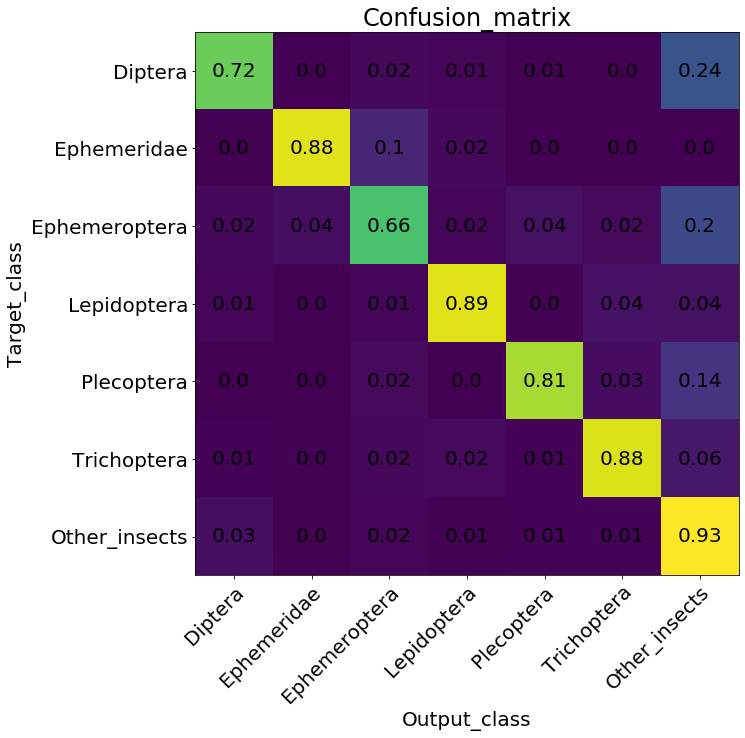

In [12]:
create_confusion_matrix(validation_matrix, ntests, args.labels, args.figure_root, save=args.save_fig)

In [13]:
each_df = compute_each_size_df(result, x_all, y_all)
if args.save_df is True:
    each_df.to_csv(pj(args.figure_root, "each_size_df.csv"))
each_df

,Accuracy,Insect_size
0,True,28855
1,True,33233
2,True,36417
3,True,35422
4,False,35621
...,...,...
3577,True,35621
3578,True,25671
3579,True,30049
3580,True,25273


In [14]:
all_df = compute_all_size_df(each_df)
if args.save_df is True:
    all_df.to_csv(pj(args.figure_root, "all_size_df.csv"))
all_df

,Accuracy,Insect_size,order
order,,,
13.0,0.790698,14351.139535,13.0
14.0,0.866330,26563.254938,14.0
15.0,0.894617,36025.487491,15.0


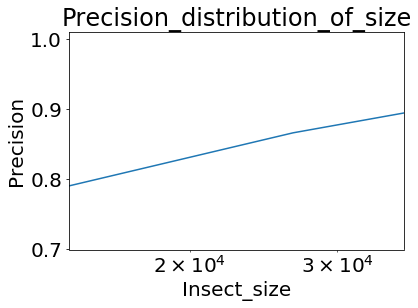

In [15]:
plot_df_distrib_size(all_df, args.figure_root, save=args.save_fig)

### Load and Test model

In [ ]:
if args.model_name="ResNet18":
    model = ResNet18(len(args.labels)).cuda()
elif args.model_name="ResNet34":
    model = ResNet34(len(args.labels)).cuda()
elif args.model_name="ResNet50":
    model = ResNet50(len(args.labels)).cuda()
elif args.model_name="ResNet101":
    model = ResNet101(len(args.labels)).cuda()
else:
    print("error! write correct model name!")

In [ ]:
model.load_state_dict(torch.load(pj(args.model_save_path_root, "final.pth")))

In [ ]:
create_dataset_from_all_data(args.all_data_path, args.train_data_path, args.test_data_path, args.test_ratio)

In [ ]:
xtr, ytr, xte, yte, ntests = load_data(args.train_data_path, args.test_data_path)

In [ ]:
matrix = confusion_matrix(model, xte, yte, args.labels, bs=args.bs)
create_confusion_matrix(matrix, ntests, args.labels, args.figure_root, save=args.save_fig)